In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import math
import csv
import re

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import pi
from scipy.fftpack import fft

LOG.propagate = False

233


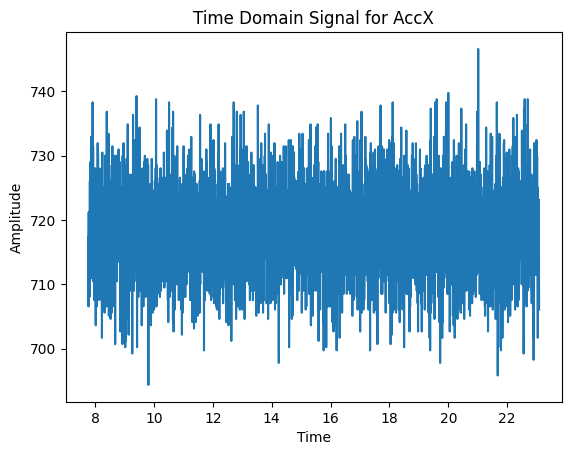

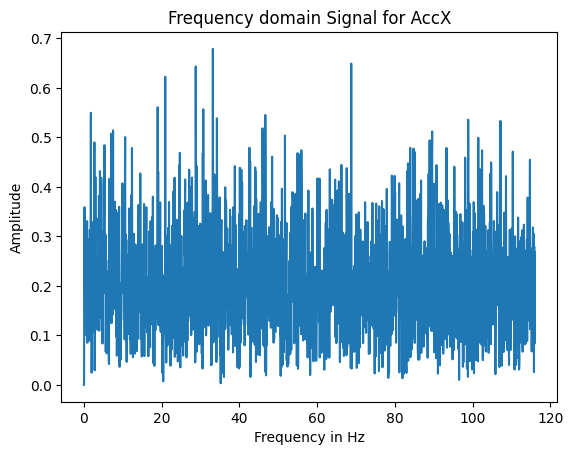

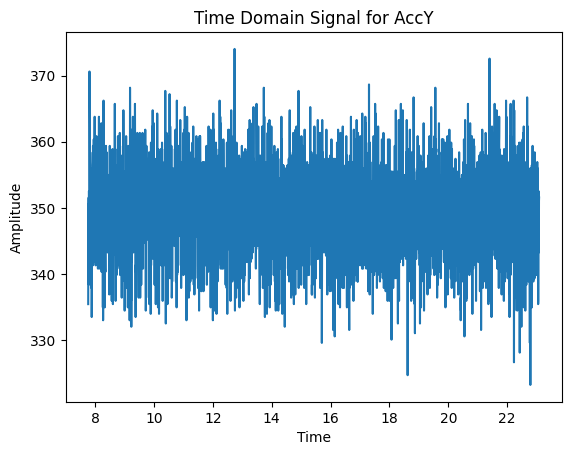

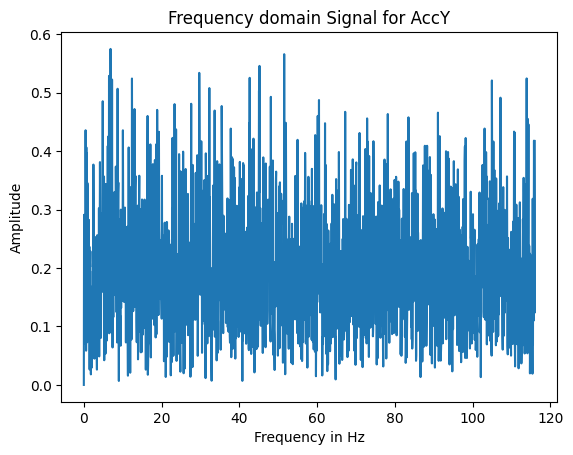

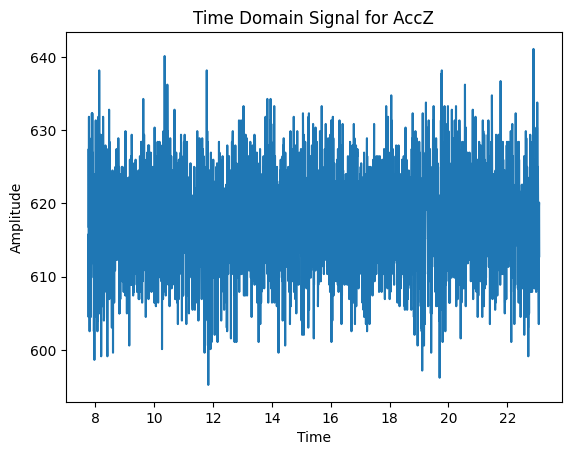

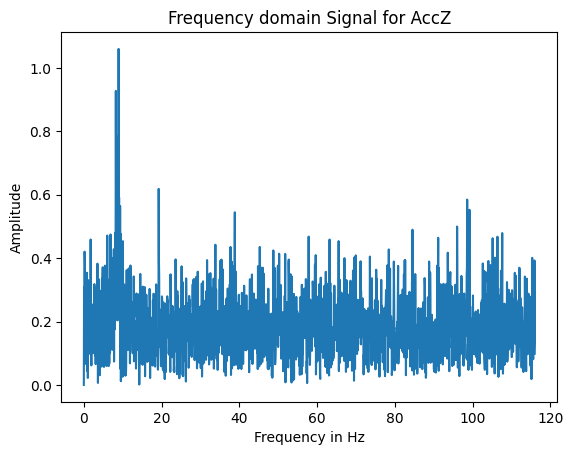

In [58]:
arr = np.loadtxt("acc_noise_data_fast.csv",
                 delimiter=",", dtype=str)
arr = arr[1:, :].astype(float)
#display(arr[1100:1200, :])

sample_rate = int(len(arr) /  (arr[len(arr)-1, 0] - arr[0, 0] ))
N = len(arr)
print(sample_rate)

frequency = np.linspace(0.0, int(sample_rate / 2), int(N/2))

for i in range(1, 4):
    axis = ["t", "X", "Y", "Z"]
    plt.plot(arr[:, 0], arr[:, i])
    plt.title ('Time Domain Signal for Acc' + axis[i])
    plt.xlabel ('Time')
    plt.ylabel ('Amplitude')
    plt.show()
    zeroed = arr[:, i] - np.average(arr[:, i])
    freq_data = fft(zeroed)
    y = 2/N * np.abs (freq_data [0: int (N/2)])
    plt.plot(frequency, y)
    plt.title('Frequency domain Signal for Acc' + axis[i])
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.show()

In [3]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

ble.send_command(CMD.PING, "")
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

2023-02-22 12:19:26,211 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:0c:66:2f:3c
2023-02-22 12:19:29,869 | INFO     |: Connected to c0:83:0c:66:2f:3c


/home/michael/Documents/Cornell/FAST-ROBOTS/FAST-ROBOTS-2023/python/base_ble.py:87: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


PONG


In [38]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

tof = []
pose = []
accel = []

CURR_LOG_ARRAY = None
log_complete = False

def ble_msg_handler(sender, msg):
    msg = msg.decode("utf-8")
    end_regex = r'<END BUFFER [a-z, A-Z]*>'
    if re.search(end_regex, msg) != None:
        print("Buffer read complete.")
        log_complete = True
    msg_regex = r'[A-Za-z]*: -?(\d*.?(?:\d*)?)' # Match Data of the form "[name]: [data]"
    data = re.findall(msg_regex, msg)
    if data == None:
        return
    if len(data) == 0:
        return
    CURR_LOG_ARRAY.append(data)

    
print("starting reading")
ble.send_command(CMD.ENABLE_BUFFER, "POSE")
ble.send_command(CMD.ENABLE_BUFFER, "ACCEL")
ble.send_command(CMD.ENABLE_BUFFER, "TOF")
time.sleep(10)
ble.send_command(CMD.DISABLE_BUFFER, "POSE")
ble.send_command(CMD.DISABLE_BUFFER, "ACCEL")
ble.send_command(CMD.DISABLE_BUFFER, "TOF")
ble.start_notify(ble.uuid['RX_STRING'], ble_msg_handler)
print("reading complete")

2023-02-22 13:02:57,219 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:0c:66:2f:3c
2023-02-22 13:03:00,203 | ERROR    |: [org.bluez.Error.Failed] le-connection-abort-by-local
2023-02-22 13:03:01,206 | WARNING  |: Attempting to connect again...
2023-02-22 13:03:01,208 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:0c:66:2f:3c
2023-02-22 13:03:04,440 | INFO     |: Connected to c0:83:0c:66:2f:3c
starting reading
reading complete


In [39]:
CURR_LOG_ARRAY = pose
ble.send_command(CMD.RETRIEVE_BUFFER, "POSE")
print("Waiting for buffer to fill...")

Waiting for buffer to fill...
Buffer read complete.


In [40]:
CURR_LOG_ARRAY = tof
ble.send_command(CMD.RETRIEVE_BUFFER, "TOF")
print("Waiting for buffer to fill...")

Waiting for buffer to fill...
Buffer read complete.


In [41]:
CURR_LOG_ARRAY = accel
ble.send_command(CMD.RETRIEVE_BUFFER, "ACCEL")
print("Waiting for buffer to fill...")

Waiting for buffer to fill...
2023-02-22 13:09:31,877 | INFO     |: Disconnected from C0:83:0C:66:2F:3C


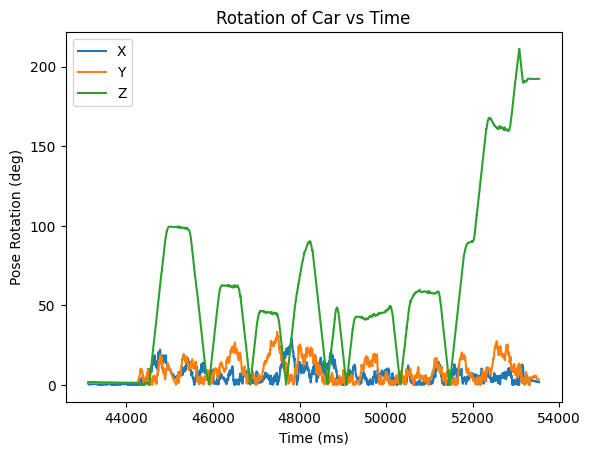

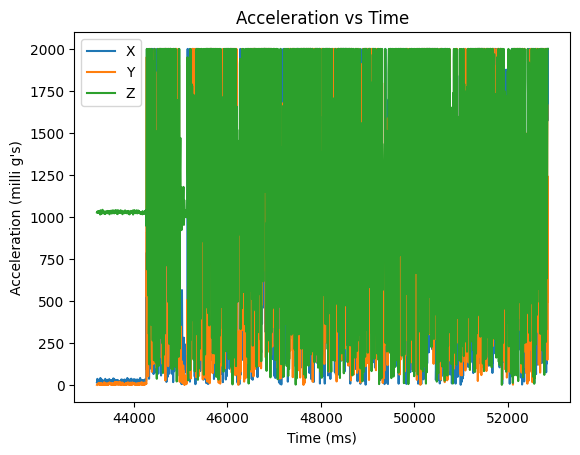

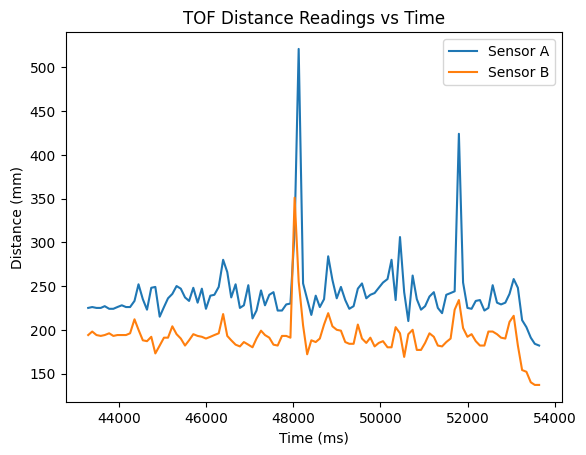

In [42]:
pose = np.array(pose).astype(float)
plt.plot(pose[:, 0], pose[:, 1])
plt.plot(pose[:, 0], pose[:, 2])
plt.plot(pose[:, 0], pose[:, 3])
plt.xlabel("Time (ms)")
plt.ylabel("Pose Rotation (deg)")
plt.title("Rotation of Car vs Time")
plt.legend(["X", "Y", "Z"])
plt.show()
accel = np.array(accel).astype(float)
plt.plot(accel[:, 0], accel[:, 1])
plt.plot(accel[:, 0], accel[:, 2])
plt.plot(accel[:, 0], accel[:, 3])
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (milli g's)")
plt.title("Acceleration vs Time")
plt.legend(["X", "Y", "Z"])
plt.show()
tof = np.array(tof).astype(float)
plt.plot(tof[:, 0], tof[:, 1])
plt.plot(tof[:, 0], tof[:, 2])
plt.xlabel("Time (ms)")
plt.ylabel("Distance (mm)")
plt.title("TOF Distance Readings vs Time")
plt.legend(["Sensor A", "Sensor B"])